# Art: Neural Style Transfer

Neural Style Transfer, an algorithm created by [Gatys et al. (2015).](https://arxiv.org/abs/1508.06576)

**In this project I:**
- Implemented the neural style transfer algorithm 
- Generated novel artistic images using algorithm 
- Defined the style cost function for Neural Style Transfer
- Defined the content cost function for Neural Style Transfer

Most of the algorithms optimize a cost function to get a set of parameter values. With Neural Style Transfer, we'll get to optimize a cost function to get pixel values.



<a name='1'></a>
## 1 - Packages

Run the following code cell to import the necessary packages and dependencies you will need to perform Neural Style Transfer.

In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
import pprint
%matplotlib inline

<a name='2'></a>
## Discription

Neural Style Transfer (NST) is one of the most fun and interesting optimization techniques in deep learning. It merges two images, namely: a <strong>"content" image (C)</strong> and a <strong>"style" image (S)</strong>, to create a <strong>"generated" image (G)</strong>. The generated image G combines the "content" of the image C with the "style" of image S. 

I am going to combine the Louvre museum in Paris (content image C) with the impressionist style of Claude Monet (content image S) to generate the following image:

<img src="louvre_generated.png" style="width:750px;height:200px;">

Let's get started!

<a name='3'></a>
## 3 - Transfer Learning


Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning. 

I will be using the the epynomously named VGG network from the [original NST paper](https://arxiv.org/abs/1508.06576) published by the Visual Geometry Group at University of Oxford in 2014. Specifically, I'll use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and has learned to recognize a variety of low level features (at the shallower layers) and high level features (at the deeper layers). 

Loading the parameters of the VGG model.

In [2]:
tf.random.set_seed(272) # DO NOT CHANGE THIS VALUE
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='pretrained-model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg.trainable = False
pp.pprint(vgg)

<a name='4'></a>
## 4 - Neural Style Transfer (NST)

building the Neural Style Transfer (NST) algorithm in three steps:

- First, build the content cost function $J_{content}(C,G)$
- Second, build the style cost function $J_{style}(S,G)$
- Finally, put it all together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$.

<a name='4-1'></a>
### 4.1 - Computing the Content Cost

<a name='4-1-1'></a>
#### 4.1.1 - Make Generated Image G Match the Content of Image C

When performing NST, the content in generated image G to match the content of image C. 

* The shallower layers of a ConvNet tend to detect lower-level features such as <i>edges and simple textures</i>.
* The deeper layers tend to detect higher-level features such as more <i> complex textures and object classes</i>. 

#### choose a "middle" activation layer $a^{[l]}$ :
* In practice, we get the most visually pleasing results if we choose a layer in the <b>middle</b> of the network--neither too shallow nor too deep. This ensures that the network detects both higher-level and lower-level features.

#### To forward propagate image "C:"
* Set the image C as the input to the pretrained VGG network, and run forward propagation.  
* Let $a^{(C)}$ be the hidden layer activations in the layer you had chosen.This will be an $n_H \times n_W \times n_C$ tensor.

#### To forward propagate image "G":
* Repeat this process with the image G: Set G as the input, and run forward progation. 
* Let $a^{(G)}$ be the corresponding hidden layer activation. 

In this running example, the content image C will be the picture of the Louvre Museum in Paris.

The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.


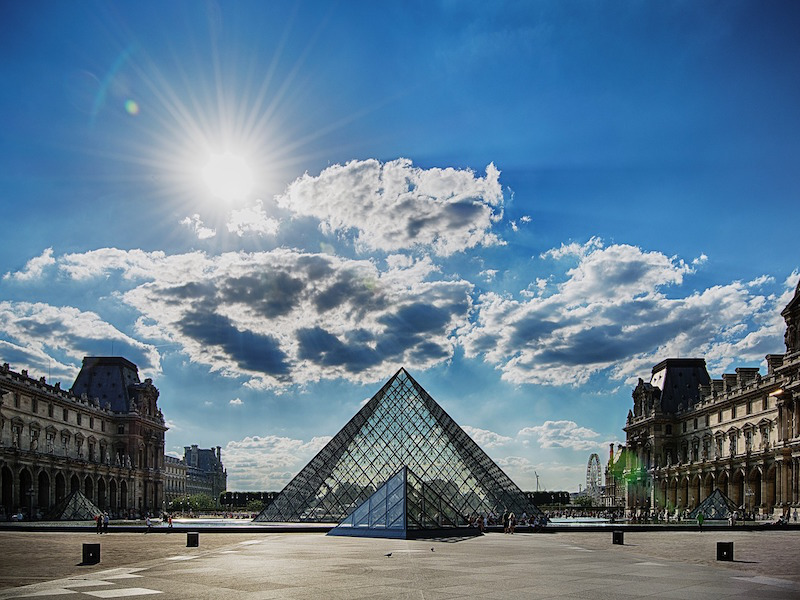

In [3]:
content_image = Image.open("images/louvre.jpg")
print("The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.")
content_image

<a name='4-1-2'></a>
#### 4.1.2 - Content Cost Function $J_{content}(C,G)$
when performing NST, the content in generated image G to match the content of image C. A method to achieve this is to calculate the content cost function, which will be defined as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

* Here, $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer you have chosen, and appear in a normalization term in the cost. 
* For clarity, note that $a^{(C)}$ and $a^{(G)}$ are the 3D volumes corresponding to a hidden layer's activations. 
* In order to compute the cost $J_{content}(C,G)$, it might also be convenient to unroll these 3D volumes into a 2D matrix, as shown below .
<img src="NST_LOSS.png" style="width:800px;height:400px;">

<a name='ex-1'></a>
## compute_content_cost

using TensorFlow. 

`a_G`: hidden layer activations representing content of the image G
<br>
`a_C`: hidden layer activations representing content of the image C 

The 3 steps to implement this function are:
1. Retrieve dimensions from `a_G`: 
2. Unroll `a_C` and `a_G` as explained in the picture above
3. Compute the content cost:
    


In [4]:


def compute_content_cost(content_output, generated_output):
   
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
   
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    
    a_C_unrolled = tf.reshape(a_C,shape=[n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G,shape=[n_H * n_W, n_C])
    
    
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C , a_G)))/(4*n_H*n_C*n_W)
    
    
    
    return J_content

<a name='4-2'></a>
### 4.2 - Computing the Style Cost

For the running example, you will use the following style image: 

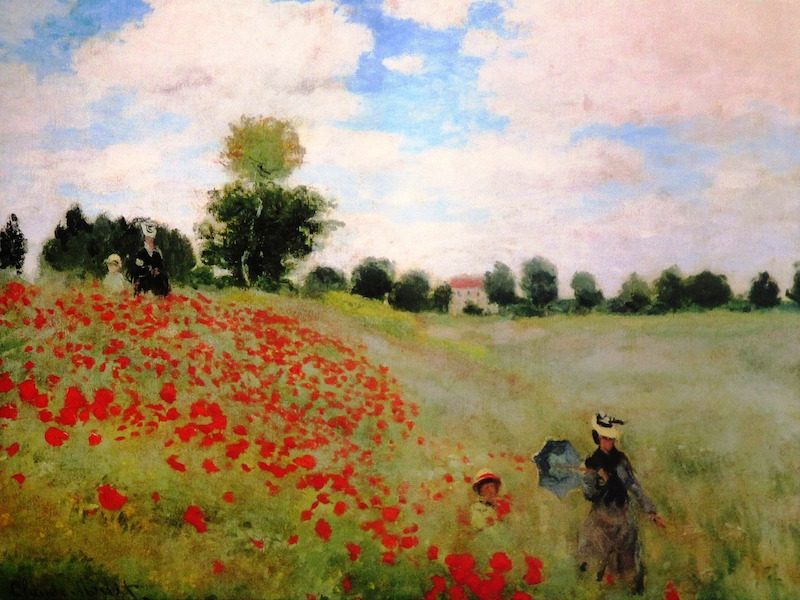

In [6]:
example = Image.open("images/monet_800600.jpg")
example

This was painted in the style of <b>[impressionism](https://en.wikipedia.org/wiki/Impressionism)</b>.


<a name='4-2-1'></a>
#### 4.2.1 - Style Matrix

#### Gram matrix
* The style matrix is also called a "Gram matrix." 
* In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. 
* In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, you would expect them to have a large dot product, and thus for $G_{ij}$ to be large. 



#### Compute Gram matrix $G_{gram}$

<img src="NST_GM.png" style="width:900px;height:300px;">

$$\mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T$$

#### $G_{(gram)ij}$: correlation
The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters (channels). The value $G_{(gram)i,j}$ measures how similar the activations of filter $i$ are to the activations of filter $j$. 
* The diagonal elements $G_{(gram)ii}$ measure how "active" a filter $i$ is. 


<a name='ex-2'></a>
### gram_matrix
* Using TensorFlow
  

In [7]:

def gram_matrix(A):
   
    
    GA = tf.matmul(A,tf.transpose(A))

    return GA

<a name='4-2-2'></a>
#### 4.2.2 - Style Cost

next will be to minimize the distance between the Gram matrix of the "style" image S and the Gram matrix of the "generated" image G. 
* use a single hidden layer $a^{[l]}$.  
* The corresponding style cost for this layer is defined as: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

* $G_{gram}^{(S)}$ Gram matrix of the "style" image.
* $G_{gram}^{(G)}$ Gram matrix of the "generated" image.


<a name='ex-3'></a>
### compute_layer_style_cost

1. Retrieve dimensions from the hidden layer activations a_G: 
2. Unroll the hidden layer activations a_S and a_G into 2D matrices.
3. Compute the Style matrix of the images S and G.
4. Compute the Style cost:

In [11]:

def compute_layer_style_cost(a_S, a_G):
    
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S,shape = [n_H*n_W,n_C]))
    a_G = tf.transpose(tf.reshape(a_G,shape = [n_H*n_W,n_C]))

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS,GG)))/(4*(n_C**2)*(n_H*n_W)**2)
    
    return J_style_layer

<a name='4-2-3'></a>
#### 4.2.3 Style Weights

* For better results "merge" style costs from several different layers. 
* Each layer will be given weights ($\lambda^{[l]}$) that reflect how much each layer will contribute to the style.
* By default, each layer has equal weight, and the weights add up to 1.  ($\sum_{l}^L\lambda^{[l]} = 1$)

Start by listing the layer names:

In [13]:
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


choosing layers to represent the style of the image and assign style costs:

In [15]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

<a name='ex-4'></a>
### compute_style_cost
* It calls  `compute_layer_style_cost(...)` several times, and weights their results using the values in `STYLE_LAYERS`.  
For each layer:
* Selects the activation (the output tensor) of the current layer.
* Gets the style of the style image "S" from the current layer.
* Gets the style of the generated image "G" from the current layer.
* Computes the "style cost" for the current layer
* Adds the weighted style cost to the overall style cost (J_style)

Once you're done with the loop:  
* Returns the overall style cost.

In [16]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    
    J_style = 0

    a_S = style_image_output[:-1]
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])
        J_style += weight[1] * J_style_layer

    return J_style

<a name='4-3'></a>
### 4.3 - Defining the Total Cost to Optimize

a cost function that minimizes both the style and the content cost. The formula is: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

<a name='ex-5'></a>
### total_cost

In [17]:

@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    
    J = alpha * J_content + beta * J_style

    return J

<a name='5'></a>
## 5 - Solving the Optimization Problem

<a name='5-1'></a>
### 5.1 Load the Content Image

(1, 400, 400, 3)


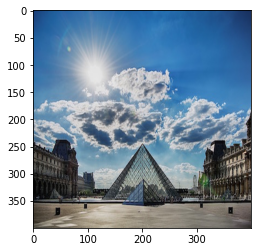

In [19]:
content_image = np.array(Image.open("images/louvre_small.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

<a name='5-2'></a>
### 5.2 Load the Style Image


(1, 400, 400, 3)


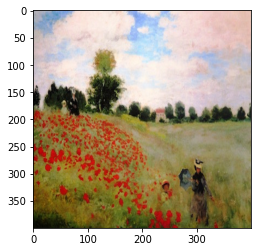

In [20]:
style_image =  np.array(Image.open("images/monet.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

<a name='5-3'></a>
### 5.3 Randomly Initialize the Image to be Generated
initializing the "generated" image as a noisy image created from the content_image.

(1, 400, 400, 3)


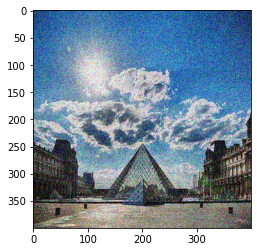

In [21]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

<a name='5-4'></a>
## 5.4 - Load Pre-trained VGG19 Model


In [22]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

defining the content layer and build the model.

In [23]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [24]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style enconder

<a name='5-5'></a>
### 5.5 - Computing Total Cost

<a name='5-5-1'></a>
#### 5.5.1 - Compute the Content image Encoding (a_C)

1. Set a_C to be the tensor giving the hidden layer activation for layer "block5_conv4" using the content image.

In [25]:
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

<a name='5-5-2'></a>
#### 5.5.2 - Compute the Style image Encoding (a_S) 

In [26]:

preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

Below are the utils that will display the images generated by the style transfer model.

In [27]:
def clip_0_1(image):
    
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

<a name='ex-6'></a>
### train_step 

* Adam optimizer to minimize the total cost `J`.
* learning rate of 0.01  

In [28]:

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        
        a_G = vgg_model_outputs(generated_image)
        
        J_style = compute_style_cost(a_S, a_G)

        J_content = compute_content_cost(a_C, a_G)
        
        J = total_cost(J_content, J_style) 
        
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))

    return J


<a name='5-6'></a>
### 5.6 - Training the Model


Epoch 0 


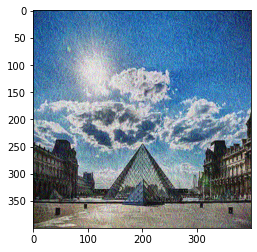

Epoch 250 


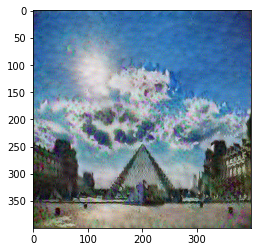

Epoch 500 


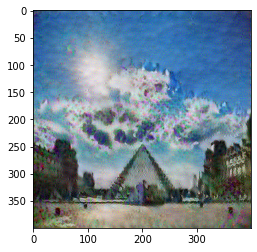

Epoch 750 


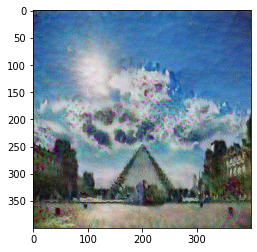

Epoch 1000 


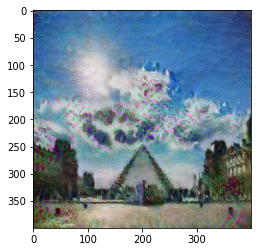

Epoch 1250 


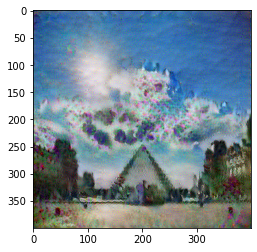

Epoch 1500 


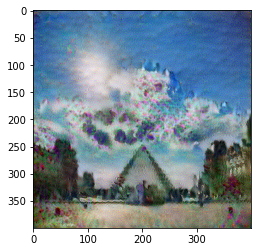

Epoch 1750 


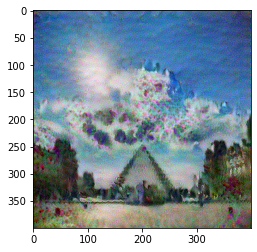

Epoch 2000 


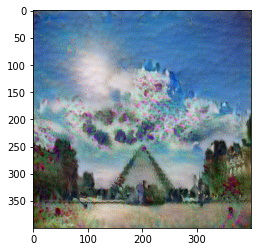

Epoch 2250 


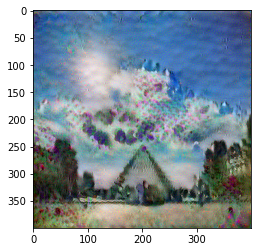

Epoch 2500 


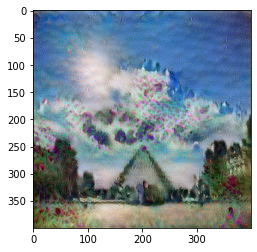

In [30]:

epochs = 2501
for i in range(epochs):
    train_step(generated_image)
    if i % 250 == 0:
        print(f"Epoch {i} ")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"output/image_{i}.jpg")
        plt.show() 

results!

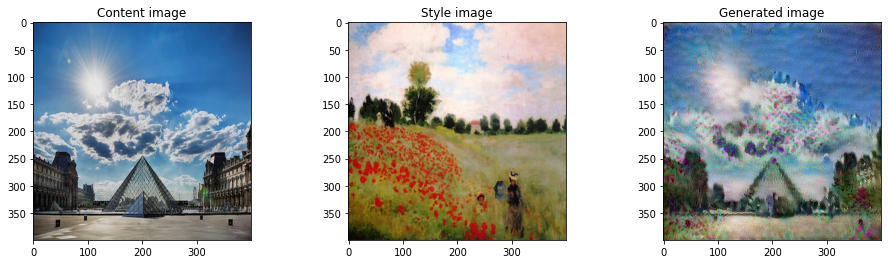

In [31]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()

Here are few other examples:

- The beautiful ruins of the ancient city of Persepolis (Iran) with the style of Van Gogh (The Starry Night)
<img src="perspolis_vangogh.png" style="width:750px;height:300px;">


- A scientific study of a turbulent fluid with the style of a abstract blue fluid painting.
<img src="circle_abstract.png" style="width:750px;height:300px;">

### Conclusion

We are now able to use Neural Style Transfer to generate artistic images. Deep learning has many different types of models and this is only one of them! 




<a name='7'></a>
## 7 - References

The Neural Style Transfer algorithm was due to Gatys et al. (2015). Harish Narayanan and Github user "log0" also have highly readable write-ups this project was inspired by. The pre-trained network used in this implementation is a VGG network, which is due to Simonyan and Zisserman (2015). Pre-trained weights were from the work of the MathConvNet team. 

- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) 
- Harish Narayanan, [Convolutional neural networks for artistic style transfer.](https://harishnarayanan.org/writing/artistic-style-transfer/)
- Log0, [TensorFlow Implementation of "A Neural Algorithm of Artistic Style".](http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style)
- Karen Simonyan and Andrew Zisserman (2015). [Very deep convolutional networks for large-scale image recognition](https://arxiv.org/pdf/1409.1556.pdf)
- [MatConvNet.](http://www.vlfeat.org/matconvnet/pretrained/)
